In [1]:
# 기본
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
from utils.calculate_loss_and_mape import calculate_loss_and_mape
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
from models.STGCN_with_auxiliary_network_model import STGCNWithAux


In [2]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [3]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# seed=42
# torch.manual_seed(seed)
# np.random.seed(seed)
# if torch.cuda.is_available():
#     # 현재 GPU에 대한 시드 고정
#     torch.cuda.manual_seed(seed)
#     # 다중 GPU 환경에서도 모두 같은 시드 고정
#     torch.cuda.manual_seed_all(seed)

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

aux_data = np.load('dataset/traffic_dataset_13_aux_smoothen.npy') # (T_aux_total, E, C) (10080, 50, 3)
aux_tensor = torch.from_numpy(aux_data).float().to(DEVICE)

In [4]:
# 공통 파라미터 및 모델 목록 정의

DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
#    "GCNMLP":    GCNMLP,
#    "DCRNN":     DCRNN,
    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
    "STGAT": STGAT,
#    "STGCNWithAux": STGCNWithAux,
}

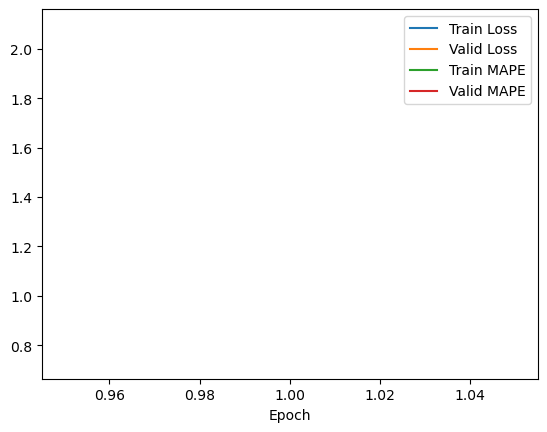

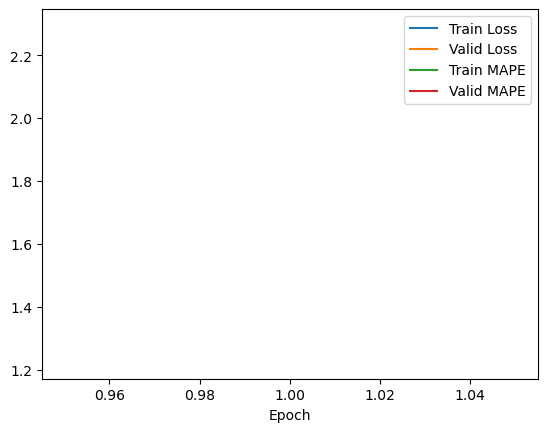

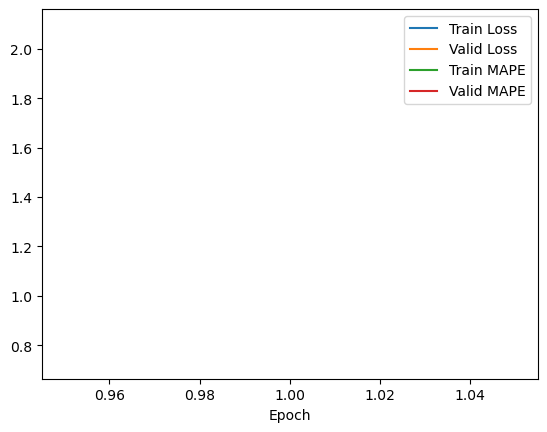

In [7]:
# Training

for name, ModelClass in models.items():
    print(f"\n=== Training {name} ===")
    # (1) 배치 데이터에서 차원 정보 추출
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    # (2) 모델 인스턴스화
    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        # GCNMLP, DCRNN, STGCN 공통 생성자 인자
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.1
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
        elif name == "STGCNWithAux":
            kwargs = dict(
                    num_nodes=E,
                    node_feature_dim=5,
                    pred_node_dim=3,
                    encoder_embed_dim=32,
                    aux_embed_dim=32,
                    aux_data=aux_tensor,
            )

        model = ModelClass(**kwargs)

    model = model.to(DEVICE)

    # (3) 옵티마이저·손실함수 설정
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    criterion = torch.nn.L1Loss()

    # (4) Trainer 초기화·학습
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=1,
        device=DEVICE,
        auto_save=True,
        save_dir=SAVE_DIR
    )
    trainer.fit()

    # (5) 가중치 저장
    # save_path = os.path.join(SAVE_DIR, f"{name}.pth")
    # torch.save(model.state_dict(), save_path)
    # print(f"Saved checkpoint: {save_path}")


이어서 학습하기

In [8]:
# trainer.get_history()로 얻은 history를 Trainer에 load하면 그래프도 이어서 그려줍니다. 

history = {'train_loss': [2.9227825364274898,
  2.805646130950786,
  2.82465965196977,
  2.77225777872101,
  2.646027212411585,
  2.5650779037086915,
  2.5342965967683044,
  2.3882038485407295,
  2.335617548768521,
  2.2518386322829693,
  2.128289003696562,
  2.049669635163691,
  1.9351897256832333,
  1.8309486666445893,
  1.7380646499717238,
  1.592475378981314,
  1.5423723881852673,
  1.3366214631737654,
  1.2786333572017885,
  1.1371887505393847,
  1.0419371888278164,
  0.9797828333942984,
  0.9341507780362576],
 'valid_loss': [2.862598161426604,
  2.789362870685919,
  2.7173326920169822,
  2.651484697458806,
  2.6076000824923424,
  2.4045441267123864,
  2.3671025867979436,
  2.239568406373825,
  2.1854216348885562,
  2.422437662684635,
  2.2032929676215662,
  2.143376787962012,
  1.9234124758231415,
  1.7871186385834898,
  1.5257491475456233,
  1.485692295515148,
  1.5290448007056339,
  1.2869111611023611,
  1.1980293154412842,
  0.8968681577243668,
  1.0914070988294426,
  1.0395093023026816,
  0.9901416633151983],
 'train_mape': [1.214997996621622,
  0.923189953500938,
  0.8894676437698013,
  0.8672335160360888,
  0.8439324654109613,
  0.8044713972605807,
  0.7566844591631445,
  0.7038740022188895,
  0.6874733420235688,
  0.6567905598641299,
  0.677865768054091,
  0.6786072702332103,
  0.6497709421401329,
  0.6293592162213713,
  0.6092587823563433,
  0.5930780417768405,
  0.567256280252024,
  0.5623673873102019,
  0.5299393583601522,
  0.5174999162934303,
  0.5104486630782418,
  0.4958170542003939,
  0.4939173329437354],
 'valid_mape': [0.8600130157267794,
  0.8330961542105224,
  0.8650202066161727,
  0.8635947275990529,
  0.8201873432135989,
  0.7444964983272524,
  0.6939478352429234,
  0.6484550490042104,
  0.6511893446373304,
  0.6682015301618957,
  0.63474598172399,
  0.6169523413323484,
  0.6219236787686564,
  0.5771342107447315,
  0.59569718548735,
  0.5432380116518151,
  0.5348707207991829,
  0.5307510553415142,
  0.4986354981420424,
  0.5740768546860912,
  0.4818040605144369,
  0.47610259438332664,
  0.4565036498324972]}

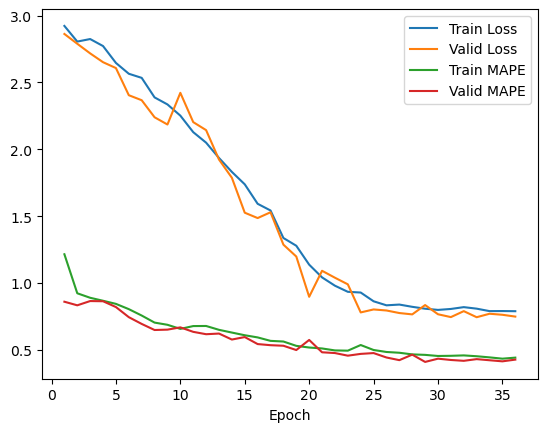

Early stopping at epoch 36


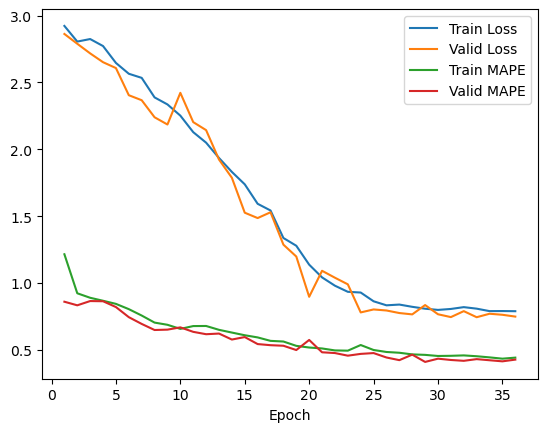

In [ ]:
# # 1) Trainer 준비 (epochs=N 은 "추가 학습할 epoch 수")
# trainer = Trainer(
#     model, train_loader, valid_loader,
#     optimizer, criterion,
#     epochs=30, device=DEVICE,
#     auto_save=True, save_dir="./checkpoints"
# )

# # 2) 외부에서 미리 로드한 가중치·history가 있으면
# trainer.load_checkpoint(
#     state_dict   = torch.load("./checkpoints/STGCNWithAux.pth"),
#     history      = history
# )

# # 3) 이어서 학습
# trainer.fit()


--- Visualizing STGCNWithAux ---


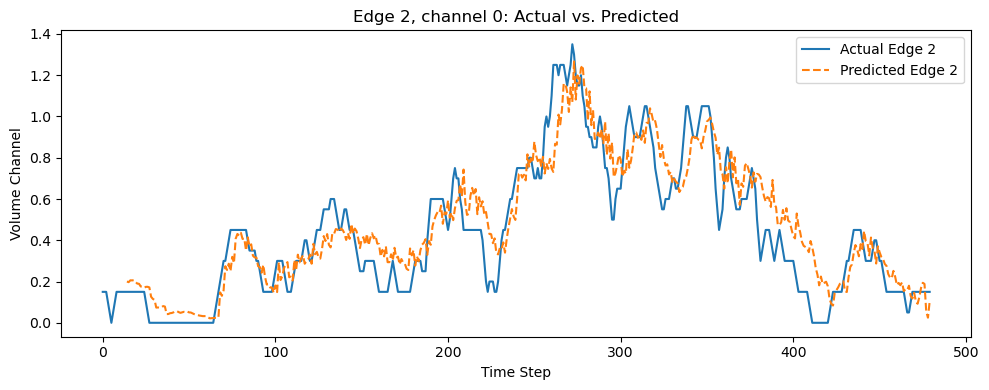

In [6]:
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from dataset.dataset_config import week_steps, C_origin
from utils.edge_prediction_visualization import visualize_predictions, add_tod_dow
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드 후 일괄 시각화
# ─────────────────────────────────────────────────────────

for name, ModelClass in models.items():
    # (1) 모델 재생성 (학습 시와 동일한 인자 사용)
    #    -- 이하 2)~3)은 학습 루프와 동일하게 구성합니다.
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.0
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
        elif name == "STGCNWithAux":
            kwargs = dict(
                    num_nodes=E,
                    node_feature_dim=5,
                    pred_node_dim=3,
                    encoder_embed_dim=32,
                    aux_embed_dim=32,
                    aux_data=aux_tensor,
            )

        model = ModelClass(**kwargs)

    # (2) 가중치 로드 (임시. 나중에 수정해야 함.)
    if name == "STGCNWithAux":
        ckpt_path = os.path.join(SAVE_DIR, f"STGCNWithAux_epoch033_val0.7441.pth")
    else:
        ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
    model = model.to(DEVICE)

    print(f"\n--- Visualizing {name} ---")
    EDGE_IDS = [2]
    expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
    visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)


In [8]:
calculate_loss_and_mape(model, valid_loader, criterion, DEVICE, EDGE_INDEX, EDGE_ATTR)

Evaluating: 100%|██████████| 105/105 [02:45<00:00,  1.58s/it]

Dataset size: 3337 samples
Average Loss: 0.7441
Average MAPE: 0.4306
